## Manuscript figures 

Notebook generates figures 3-10 and tables 4-6 in Krell et al. (2021) Water Resources Research.

In [1]:
## Import packages
## We need to add the module path to our system path so 
## so that our notebook can find our local objects and code:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
     
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os
from math import exp
import seaborn as sns
import sys
import glob
from dateutil.relativedelta import *
from numpy.random import exponential, uniform
import scipy.stats as st
from statistics import mean

# Import objects
from farm import Climate
from farm import Soil
from farm import Crop
from farm import StaticCrop
from farm import CropModel, ZeroECropModel
from farm.functions import *
from farm.climate import make_climate_parameters, check_exponential, Climate

from exponential_model.functions import *
import warnings
warnings.filterwarnings("ignore")
# Set background color
# plot.rc['figure.facecolor'] = 'white'
# plot.rc.axesfacecolor = 'white'

In [2]:
## Figure 4. Time series of T, E, and E+T

# Set OL JOGI climatology for the following figures
station = 'OL JOGI FARM'
interval='dekad'
data_file="../data/CETRAD/CETRAD_rainfall.csv"
texture='clay loam'

#TODO: create input rainfall using generate
a_mid, l_mid, sd = make_climate_parameters(data_file = data_file, station=station, interval=interval) 


# Make a dataframe with these alphas and lambdas
df_mid = pd.DataFrame({'alpha':a_mid, 'lambda':l_mid, 'dekad':np.arange(1,38,1),'doy':['10','20','30','40',
                                                                           '50','60','70','80','90','100',
                                                                            '110','120','130','140','150','160',
                                                                             '170','180','190','200','210','220',
                                                                             '230','240','250','260','270','280','290',
                                                                              '300','310','320','330','340','350','360','365'
                                                                              ]})

def run_tau_models(ET_max=6.5, const_kc=1.2, q_t=0.01, loss_func_plot=False, drydown_plot=False):

    ### Crop model ###
    climate = Climate(
            data_file=data_file,
            station=station,
            interval=interval,
            alpha_r = a_mid,
            lambda_r = l_mid,
            ET_max = ET_max,
            do_std=False)
        
    soil = Soil(texture)
    # crop0 = Crop()
    crop = StaticCrop(soil=soil, const_kc=const_kc, q_t=q_t)
    soil.set_nZr(crop)  
    model = CropModel(crop=crop,soil=soil,climate=climate)
    # model = ZeroECropModel(crop=crop,soil=soil,climate=climate)

    #TODO: Add warm-up period
    model.run(
        planting_date=100,
        t_before=100,
        t_after=7,
        t_warmup=365
        )

    # Set saturation variable
    s = np.arange(0, 1, 0.0056) #saturation

    # Convert to vwc
    vwc = s*Soil(texture).n 

    output = model.output()

    if loss_func_plot:
        lai=output.LAI[0]
        plt.plot(s, [crop.calc_T(x, LAI=lai) for x in s], '-', linewidth=2)
        plt.plot(s, [climate.calc_E(x, LAI=lai, sh=0.42) for x in s],'--', linewidth=2)
        plt.plot(s, [crop.calc_T(x, LAI=lai) + climate.calc_E(x, LAI=lai, sh=0.42) for x in s],':', linewidth=2)
        # plt.plot(s, [0 for x in s],'--', linewidth=2)
        # plt.plot(s, [crop.calc_T(x, LAI=lai) for x in s],':', linewidth=2)

        plt.xlabel('Relative soil moisture content [s]') 
        plt.ylabel('$\mathit{T}$, $\mathit{E}$, $\mathit{E+T}$ [mm/day]') 
        plt.legend(['$\mathit{T}$', '$\mathit{E}$','$\mathit{E+T}$'], frameon=False)
        plt.ylim(-0.1,5.5)
        plt.xlim(0,1)

    ### Drydown detection ###

    precip_thresh = 2
    # SMAP paper: Any positive increment smaller than 5% of the observed range of soil moisture at the site is excluded if it would otherwise truncate a drydown. 
    # This criteria is not included because this is model
    dSdt_noise_thresh = 0 #(output.s.max() - output.s.min()) * 0.05
    # To avoid noise creating spurious drydowns, identified drydowns were excluded from the analysis when the positive increment preceding the drydown was less than two times the target unbiased root-mean-square difference for SMAP observations (0.08).
    dSdt_positive_thresh = 0
    
    drydown_events = calc_dSdt(cropmodel_output=output, precip_thresh=precip_thresh, dSdt_positive_thresh=dSdt_positive_thresh, dSdt_noise_thresh=dSdt_noise_thresh, plot_results=drydown_plot)

    min_s = output.s.min()
    drydown_params = []

    ### Exp fits  ###
    for i, event in drydown_events.iterrows():
        fit_param = fit_exp_model(event, min_sm_values_at_the_pt=min_s)
        drydown_params.append(fit_param)

    df_drydown_params = pd.DataFrame(drydown_params)

    ### Export ###
    drydown_and_params = pd.merge(drydown_events, df_drydown_params.drop(columns='delta_theta'), on=['event_start', 'event_end'], how='outer')
    drydown_and_params.to_csv(r'..\output\ryoko_debug\test.csv')

    return drydown_and_params


Laikipia station data was inputted.


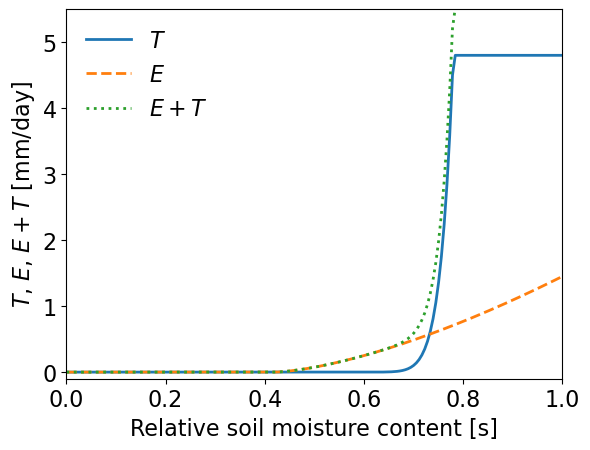

In [5]:
test = run_tau_models(loss_func_plot=True, q_t=10)

In [6]:
q_t_range = [0.01, 0.2, 0.7, 1, 2, 5, 10]
# ET_max_range = np.arange(0, 8+1, 1)
# LAI_range = np.arange(2, 4.5, 0.3125)
# kc_range = np.arange(0, 1.1, 0.1375)
# kc_range
# ET_max = 7.0
# const_kc = 0.5

In [7]:
ds_drydown_and_params = pd.DataFrame()
for i, q_t in enumerate(q_t_range):
    print(f"Index: ({i}), ET_max: 6.5, const_kc: 1.2, q_t: {q_t}")
    try:
        for i in range(10):
            drydown_and_params = run_tau_models(q_t=q_t, drydown_plot=False)
            drydown_and_params['ET_max'] = 6.5
            drydown_and_params['q_t'] = q_t
            ds_drydown_and_params = pd.concat([ds_drydown_and_params, drydown_and_params])
    except:
        continue
ds_drydown_and_params = ds_drydown_and_params.sort_index()

Index: (0), ET_max: 6.5, const_kc: 1.2, q_t: 0.01
Laikipia station data was inputted.
Laikipia station data was inputted.
Laikipia station data was inputted.
Laikipia station data was inputted.
Laikipia station data was inputted.
Laikipia station data was inputted.
Laikipia station data was inputted.
Laikipia station data was inputted.
Laikipia station data was inputted.
Laikipia station data was inputted.
Index: (1), ET_max: 6.5, const_kc: 1.2, q_t: 0.2
Laikipia station data was inputted.
Laikipia station data was inputted.
Laikipia station data was inputted.
Laikipia station data was inputted.
Laikipia station data was inputted.
Laikipia station data was inputted.
Laikipia station data was inputted.
Laikipia station data was inputted.
Laikipia station data was inputted.
Laikipia station data was inputted.
Index: (2), ET_max: 6.5, const_kc: 1.2, q_t: 0.7
Laikipia station data was inputted.
Laikipia station data was inputted.
Laikipia station data was inputted.
Laikipia station data wa

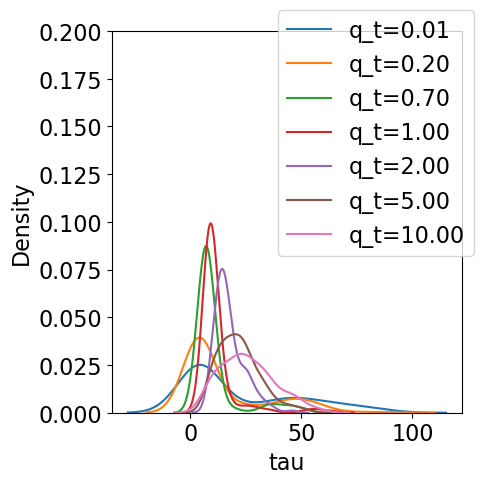

In [8]:
fig = plt.figure(figsize=(5, 5), tight_layout=True)
ax = fig.add_subplot()
cmap = plt.cm.get_cmap('Blues')
norm = plt.Normalize(vmin=0.01, vmax=10)

for i, q_t in enumerate(q_t_range):
    x = ds_drydown_and_params[ds_drydown_and_params["q_t"]==q_t]["tau"]
    sns.kdeplot(x, label=f"q_t={q_t:.2f}") #, kde=True, hist=True, color=cmap(norm(i+1)), label=f"q_t={q_t:.2f}")

    # ax.hist(x, bins=20, range=(0, 40), color=cmap(norm(i+1)), density=True, alpha=0.5, label=f"q_t={q_t:.2f}")
# ax.set_ylim(0, 1)
ax.set_ylim(0, 0.2)
fig.legend()

Laikipia station data was inputted.


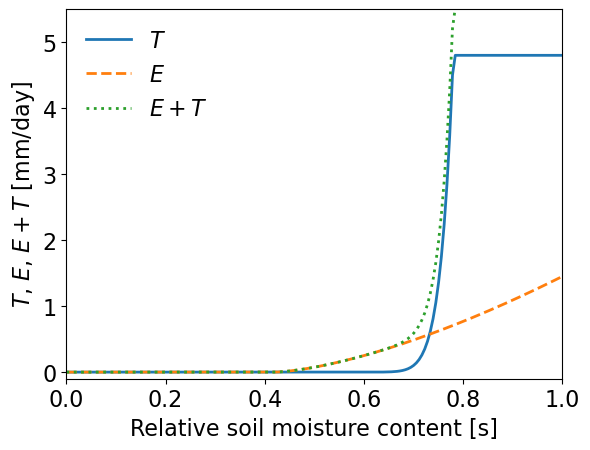

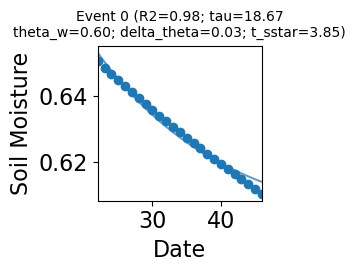

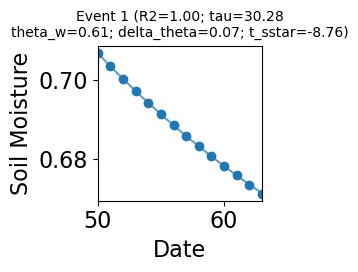

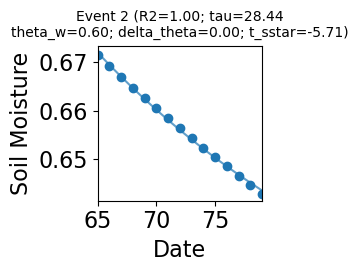

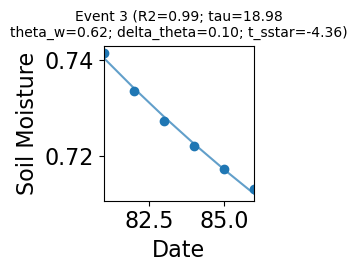

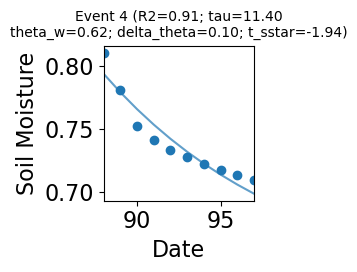

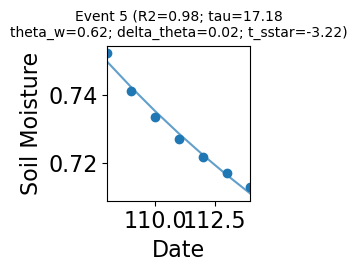

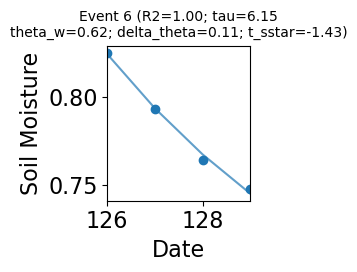

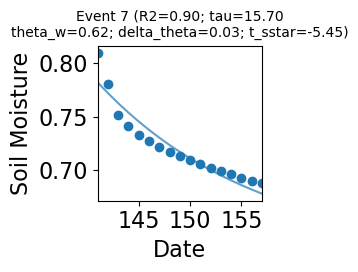

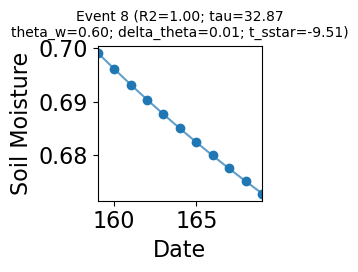

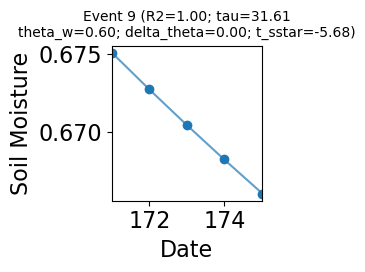

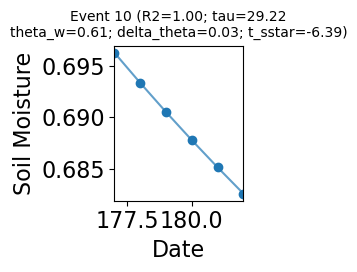

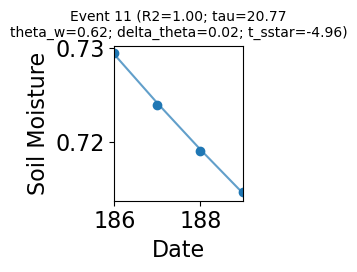

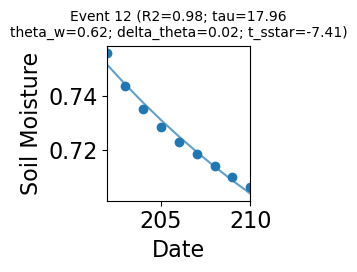

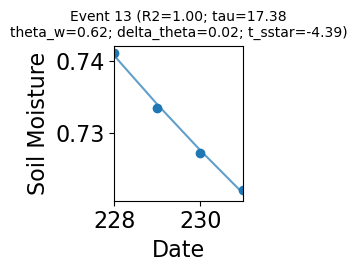

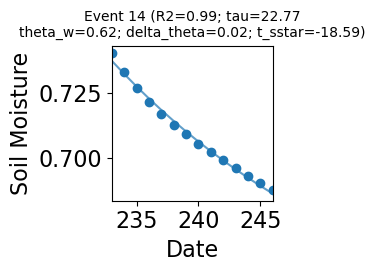

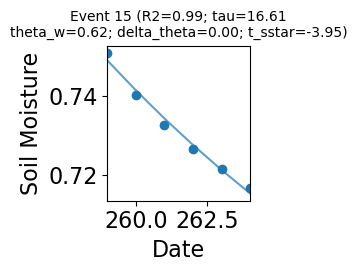

In [9]:
drydown_and_params = run_tau_models(q_t=10, loss_func_plot=True)
for index, drydown_event in drydown_and_params.iterrows():
    plot_expfit_results(index, drydown_event)